In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pylab 

In [2]:
## https://jonchar.net/notebooks/matplotlib-styling/
from matplotlib import rc

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})

In [3]:

%matplotlib inline

# The following %config line changes the inline figures to have a higher DPI.
# You can comment out (#) this line if you don't have a high-DPI (~220) display.
%config InlineBackend.figure_format = 'retina'

In [4]:
def stylize_axes(ax, title, xlabel, ylabel):
    """Customize axes spines, title, labels, ticks, and ticklabels."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_tick_params(top='off', direction='out', width=1)
    ax.yaxis.set_tick_params(right='off', direction='out', width=1)
    
    ax.set_title(title)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [5]:
import re
def get_data(root_folder):
    file_name = "policy_log"
    
    list_real = []
    with open('%s/%s.txt' % (root_folder, file_name), 'r') as f:
        for line in f:
            ls = line.strip()
            match = re.search(r'iter (\d+) \[(.*)\] \[(.*)\]', ls)

            if match:
                iter, val, real = match.group(1), match.group(2), match.group(3)

            final_real = float(real.split(",")[-1])
            list_real.append(final_real)
            
    return list_real

In [6]:
root = "../results/nips/forward"
def plot_new_data(root_folder, n_datapoint, color, linestyle, label):
    
    list_reals = []
    min_idx = 500
    for f in root_folder:
        list_real = -np.array(get_data(f))
        list_reals.append(list_real)
        
        if min_idx > len(list_real):
            min_idx = len(list_real)
        
    arr_costs = np.array([real[:min_idx] for real in list_reals])
    cost_mean = np.mean(arr_costs, axis=0)
    cost_std  = np.std(arr_costs, axis=0)
#     print([len(real) for real in list_reals])

    ts = np.arange(n_datapoint, (len(cost_mean)+1)*n_datapoint, n_datapoint)
    pylab.plot(ts, cost_mean, color, linestyle=linestyle, label=label)
    pylab.fill_between(ts, cost_mean-cost_std, cost_mean+cost_std, color=color, linestyle=linestyle, alpha=0.1)

all_folders = []

envs = ["swimmer" ,"hopper", "half_cheetah", "ant"]
names = ["Swimmer", "Hopper", "Half Cheetah", "Ant"]
all_n_datapoints = {"swimmer": [2000 for _ in range(6)],
               "hopper": [2000 for _ in range(6)],
               "half_cheetah": [2000 for _ in range(6)],
               "ant": [2000, 2000, 4000, 4000, 2000, 2000]}
min_rewards = [0, -250, -50, 0]
max_rewards = [40, 270, 200, 330]

In [7]:
def plot_ax_data(ax, root_folder, n_datapoint, color, linestyle, label):
    
    list_reals = []
    min_idx = 500
    for f in root_folder:
        try:
            list_real = -np.array(get_data(f))
        except:
            print("Not found %s" % f)
            continue
        
#         list_real = -np.array(get_data(f))
        list_reals.append(list_real)
        
        if min_idx > len(list_real):
            min_idx = len(list_real)
        
    arr_costs = np.array([real[:min_idx] for real in list_reals])
    cost_mean = np.mean(arr_costs, axis=0)
    cost_std  = np.std(arr_costs, axis=0)

    ts = np.arange(n_datapoint, (len(cost_mean)+1)*n_datapoint, n_datapoint)
    hand = ax.plot(ts, cost_mean, color, linestyle=linestyle, label=label)
    ax.fill_between(ts, cost_mean-cost_std, cost_mean+cost_std, color=color, linestyle=linestyle, alpha=0.1)
    
    return ax, hand, ts

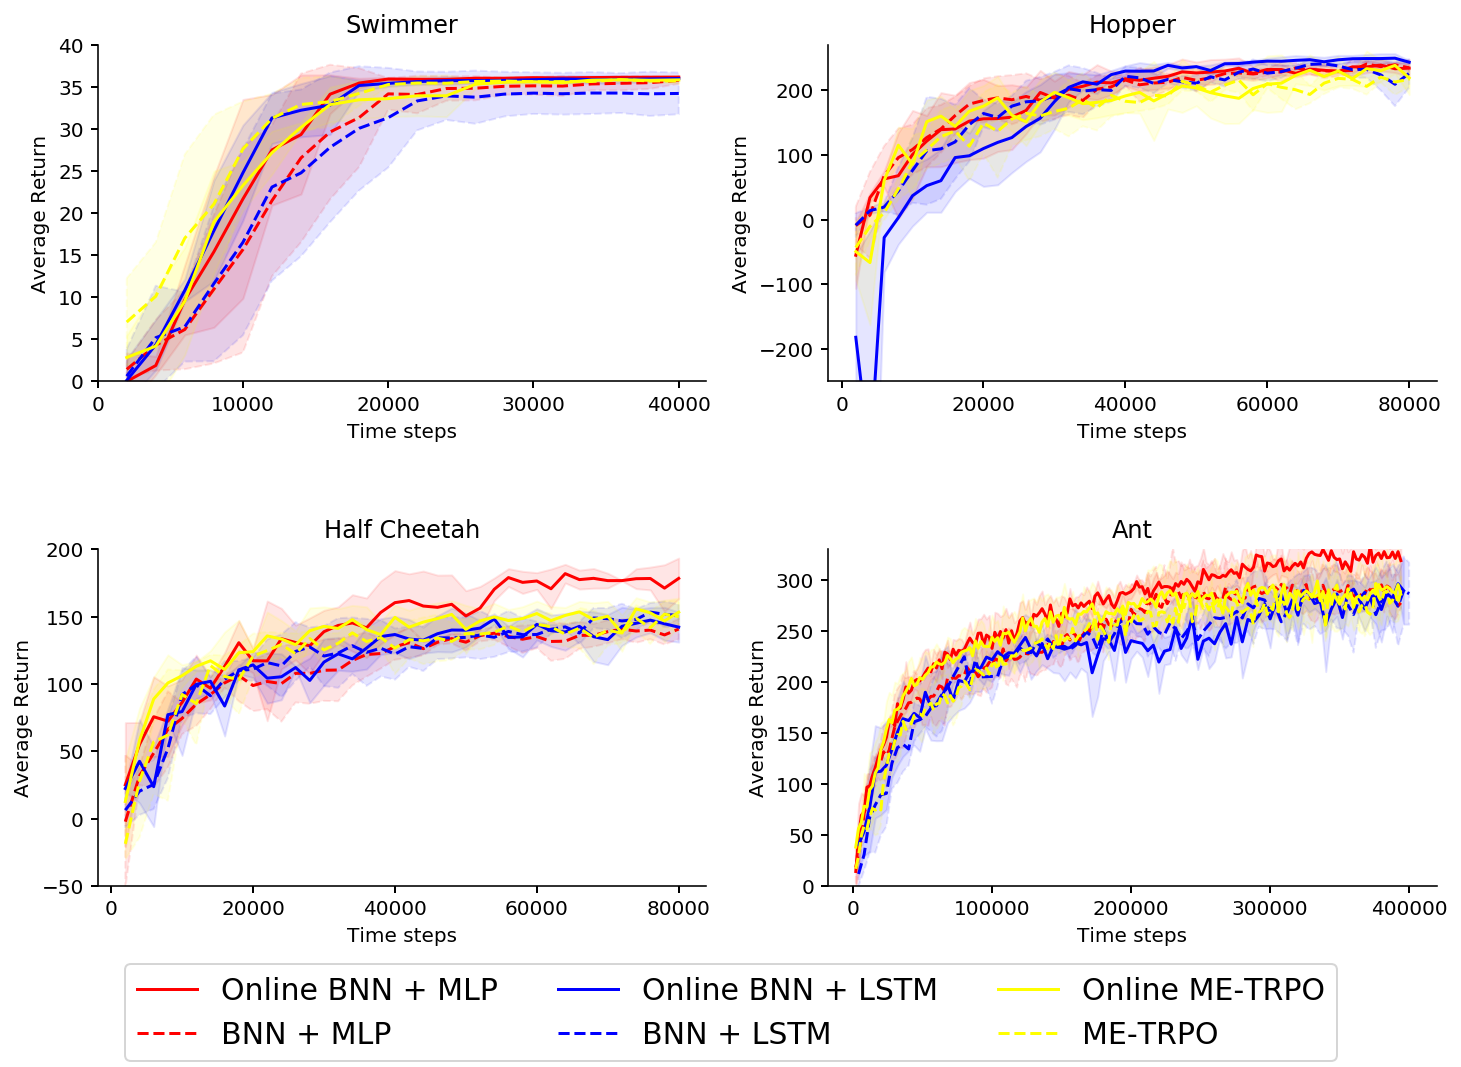

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
# fig.tight_layout()

i = 0

x_ticks = {"swimmer": [i*10**4 for i in range(5)],
           "hopper": [2*i*10**4 for i in range(5)],
           "half_cheetah": [2*i*10**4 for i in range(5)],
           "ant": [10*i*10**4 for i in range(5)]}

for env, name, min_reward, max_reward in zip(envs, names, min_rewards, max_rewards):
    
    x = int(i / 2)
    y = i % 2

    handles = []
    colors = ['r', 'r', 'blue', 'blue', 'yellow', 'yellow']
    linestyles = ['-', '--', '-', '--', '-', '--']
    
    labels = ["Online BNN + MLP", "BNN + MLP", "Online BNN + LSTM", "BNN + LSTM", "Online ME-TRPO", "ME-TRPO"]
    models = ["continual_bnn_trpo_con_vs_nonc", "non_continual_bnn_trpo_con_vs_nonc", 
              "continual_bnn_trpo_con_vs_nonc", "non_continual_bnn_trpo_con_vs_nonc",
              "continual_me_trpo_con_vs_nonc", "non_continual_me_trpo_con_vs_nonc"]
    policy = ["", "", "_lstm", "_lstm", "", ""]
    n_datapoints = all_n_datapoints[env]
    
    for p, m, c, ls, l, ndata in zip(policy, models, colors, linestyles, labels, n_datapoints):
        root_folder = ["%s/%s%s/%s/%d" % (root, env, p, m, i) for i in [0, 1, 2]]
        all_folders += root_folder
        _, hand, ts = plot_ax_data(ax[x, y], root_folder, ndata, c, ls, l)
        handles.append(hand[0])
        
    ax[x, y].set_xticks(x_ticks[env])
    ax[x, y].set_ylim(min_reward, max_reward)
    stylize_axes(ax[x, y], name, "Time steps", "Average Return")
        
    i += 1
        
# ax.legend(handles, labels, bbox_to_anchor=(0.01, 0), loc = 'lower right')
fig.legend(handles,     # The line objects
           labels,   # The labels for each line
           loc="lower center",   # Position of legend
           borderaxespad=0.2,    # Small spacing around legend box
           ncol=3,
           prop={'size': 15}
           )

pylab.subplots_adjust(bottom=0.15, hspace=0.5)

fig.savefig("%s/forward_comparison.png" % ("../results/nips"), dpi=800, bbox_inches='tight')

Not found ../results/nips/forward_same/swimmer_mlp/non_continual_bnn_trpo_con_vs_nonc/2
Not found ../results/nips/forward_same/hopper_mlp/non_continual_bnn_trpo_con_vs_nonc/2
Not found ../results/nips/forward_same/hopper_mlp/continual_me_trpo_con_vs_nonc/2
Not found ../results/nips/forward_same/hopper_mlp/non_continual_me_trpo_con_vs_nonc/2
Not found ../results/nips/forward_same/half_cheetah_mlp/non_continual_bnn_trpo_con_vs_nonc/2
Not found ../results/nips/forward_same/half_cheetah_mlp/continual_me_trpo_con_vs_nonc/2
Not found ../results/nips/forward_same/half_cheetah_mlp/non_continual_me_trpo_con_vs_nonc/2
Not found ../results/nips/forward_same/ant_mlp/continual_bnn_trpo_con_vs_nonc/1


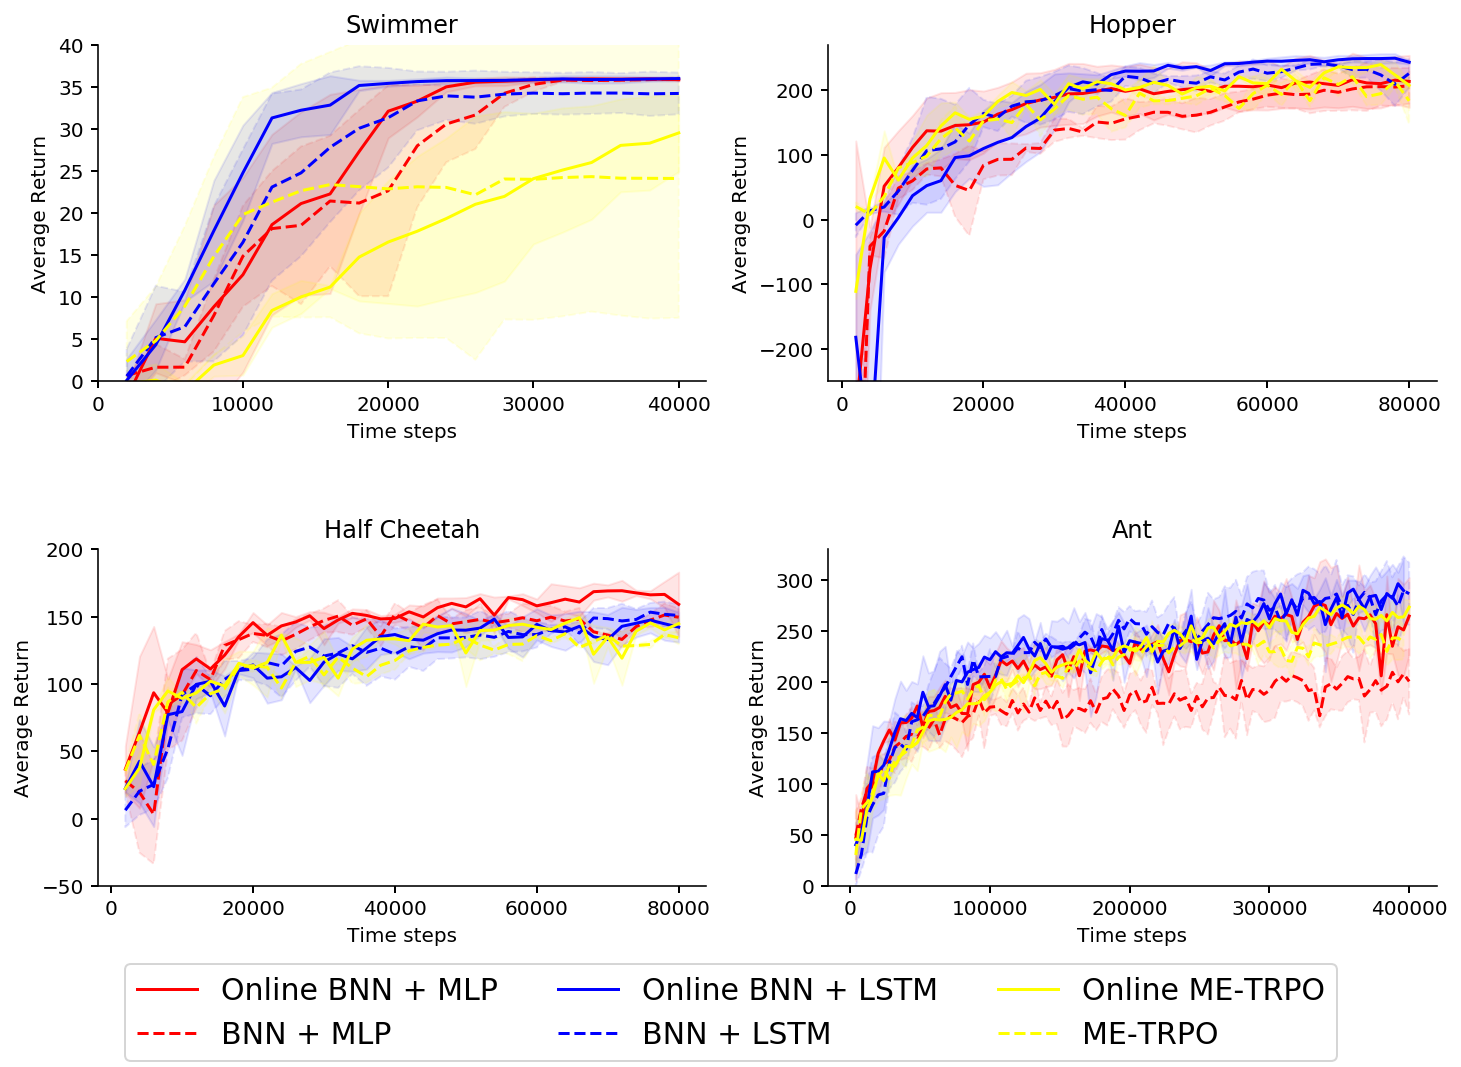

In [14]:
root = "../results/nips/forward_same"
all_folders = []

envs = ["swimmer" ,"hopper", "half_cheetah", "ant"]
names = ["Swimmer", "Hopper", "Half Cheetah", "Ant"]
all_n_datapoints = {"swimmer": [2000 for _ in range(6)],
               "hopper": [2000 for _ in range(6)],
               "half_cheetah": [2000 for _ in range(6)],
               "ant": [4000 for _ in range(6)]}
min_rewards = [0, -250, -50, 0]
max_rewards = [40, 270, 200, 330]

x_ticks = {"swimmer": [i*10**4 for i in range(5)],
           "hopper": [2*i*10**4 for i in range(5)],
           "half_cheetah": [2*i*10**4 for i in range(5)],
           "ant": [10*i*10**4 for i in range(5)]}

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
# fig.tight_layout()

i = 0

for env, name, min_reward, max_reward in zip(envs, names, min_rewards, max_rewards):
    
    x = int(i / 2)
    y = i % 2

    handles = []
    colors = ['r', 'r', 'blue', 'blue', 'yellow', 'yellow']
    linestyles = ['-', '--', '-', '--', '-', '--']
    
    labels = ["Online BNN + MLP", "BNN + MLP", "Online BNN + LSTM", "BNN + LSTM", "Online ME-TRPO", "ME-TRPO"]
    models = ["continual_bnn_trpo_con_vs_nonc", "non_continual_bnn_trpo_con_vs_nonc",
              "continual_bnn_trpo_con_vs_nonc", "non_continual_bnn_trpo_con_vs_nonc",
              "continual_me_trpo_con_vs_nonc", "non_continual_me_trpo_con_vs_nonc"]
    ablation = ["", "", "", "", "", ""]
    policy = ["_mlp", "_mlp", "_lstm", "_lstm", "_mlp", "_mlp"]

    n_datapoints = all_n_datapoints[env]
    
    for a, p, m, c, ls, l, ndata in zip(ablation, policy, models, colors, linestyles, labels, n_datapoints):
        root_folder = ["%s/%s%s%s/%s/%d" % (root, a, env, p, m, i) for i in [0, 1, 2]]
        all_folders += root_folder
        _, hand, ts = plot_ax_data(ax[x, y], root_folder, ndata, c, ls, l)
        handles.append(hand[0])
        
    ax[x, y].set_xticks(x_ticks[env])                                  
    ax[x, y].set_ylim(min_reward, max_reward)
    stylize_axes(ax[x, y], name, "Time steps", "Average Return")
        
    i += 1
        
# ax.legend(handles, labels, bbox_to_anchor=(0.01, 0), loc = 'lower right')
fig.legend(handles,     # The line objects
           labels,   # The labels for each line
           loc="lower center",   # Position of legend
           borderaxespad=0.2,    # Small spacing around legend box
           ncol=3,
           prop={'size': 15}
           )

pylab.subplots_adjust(bottom=0.15, hspace=0.5)

# fig.savefig("%s/forward_same_comparison.png" % ("../results/nips"), dpi=800, bbox_inches='tight')

Not found ../results/nips/forward_ablation/ant_10k_mlp/continual_bnn_trpo_con_vs_nonc/1


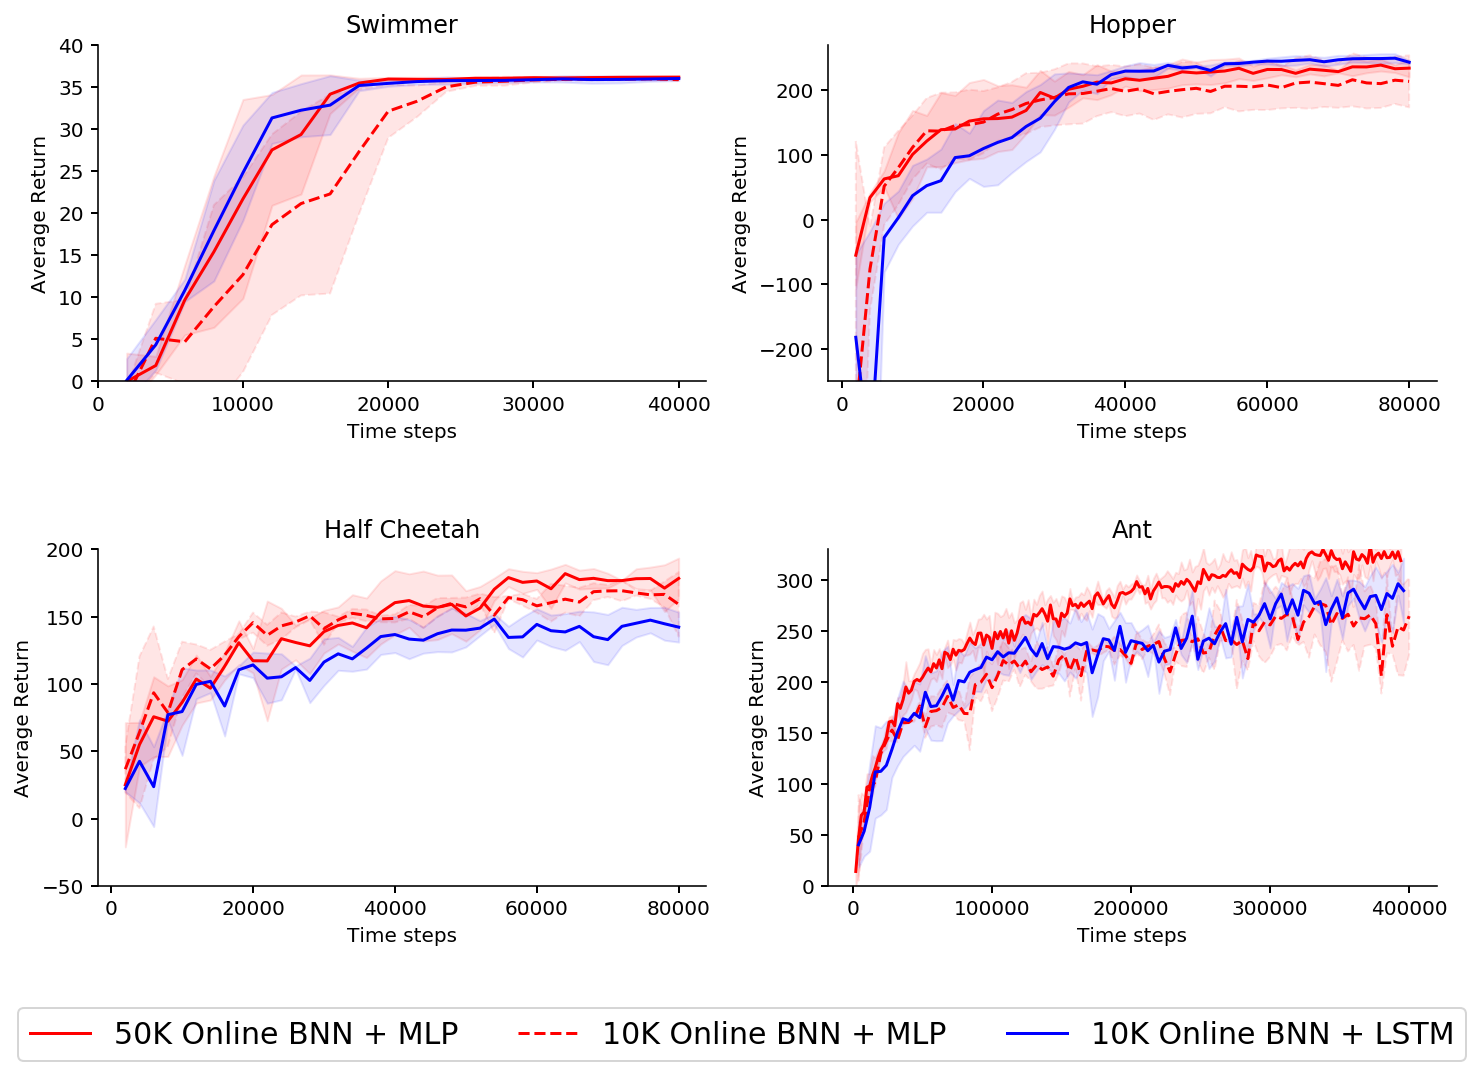

In [10]:
root = "../results/nips/forward_ablation"
all_folders = []

envs = ["swimmer" ,"hopper", "half_cheetah", "ant"]
names = ["Swimmer", "Hopper", "Half Cheetah", "Ant"]
all_n_datapoints = {"swimmer": [2000 for _ in range(3)],
               "hopper": [2000 for _ in range(3)],
               "half_cheetah": [2000 for _ in range(3)],
               "ant": [2000, 4000, 4000]}
min_rewards = [0, -250, -50, 0]
max_rewards = [40, 270, 200, 330]

x_ticks = {"swimmer": [i*10**4 for i in range(5)],
           "hopper": [2*i*10**4 for i in range(5)],
           "half_cheetah": [2*i*10**4 for i in range(5)],
           "ant": [10*i*10**4 for i in range(5)]}

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
# fig.tight_layout()

i = 0

for env, name, min_reward, max_reward in zip(envs, names, min_rewards, max_rewards):
    
    x = int(i / 2)
    y = i % 2

    handles = []
    colors = ['r', 'r', 'blue']
    linestyles = ['-', '--', '-']
    
    labels = ["50K Online BNN + MLP", "10K Online BNN + MLP", "10K Online BNN + LSTM"]
    models = ["continual_bnn_trpo_con_vs_nonc", "continual_bnn_trpo_con_vs_nonc", "continual_bnn_trpo_con_vs_nonc"]
    ablation = ["", "", ""]
    policy = ["_50k_mlp", "_10k_mlp", "_lstm"]

    n_datapoints = all_n_datapoints[env]
    
    for a, p, m, c, ls, l, ndata in zip(ablation, policy, models, colors, linestyles, labels, n_datapoints):
        root_folder = ["%s/%s%s%s/%s/%d" % (root, a, env, p, m, i) for i in [0, 1, 2]]
        all_folders += root_folder
        _, hand, ts = plot_ax_data(ax[x, y], root_folder, ndata, c, ls, l)
        handles.append(hand[0])
        
    ax[x, y].set_xticks(x_ticks[env])                                  
    ax[x, y].set_ylim(min_reward, max_reward)
    stylize_axes(ax[x, y], name, "Time steps", "Average Return")
        
    i += 1
        
# ax.legend(handles, labels, bbox_to_anchor=(0.01, 0), loc = 'lower right')
fig.legend(handles,     # The line objects
           labels,   # The labels for each line
           loc="lower center",   # Position of legend
           borderaxespad=0.2,    # Small spacing around legend box
           ncol=3,
           prop={'size': 15}
           )

pylab.subplots_adjust(bottom=0.15, hspace=0.5)

fig.savefig("%s/forward_ablation_comparison.png" % ("../results/nips"), dpi=800, bbox_inches='tight')

In [15]:
import json
def load_params(param_path):
    with open(param_path, 'r') as f:
        params = json.load(f)

    return params

print("%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s" % ("Env", "Model", "Policy", "Iters", "#Models", "BatchSize", "Scale", "InnerIters", "InnerBatchSize"))
for folder in all_folders:
    try:
        params = load_params("%s/params.json" % folder)
    except:
        print("Not found %s" % folder)
        continue
    
    dyn_params = params["dynamics_params"]
    dyn_opt_params = params["dynamics_opt_params"]
    pol_opt_params = params["policy_opt_params"]
    pol_type = "lstm" if "lstm" in folder else "mlp"
    print("%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s" % (params["env"], params["model"], pol_type, params["sweep_iters"], 
          dyn_params["n_nets"], dyn_opt_params["batch_size"], dyn_opt_params["scale"],
          pol_opt_params["max_iters"], pol_opt_params["trpo"]["batch_size"])
         )

Env	Model	Policy	Iters	#Models	BatchSize	Scale	InnerIters	InnerBatchSize
swimmer	BNN	mlp	20	20	100	5.0	100	5000
swimmer	BNN	mlp	20	20	100	5.0	100	5000
swimmer	BNN	mlp	20	20	100	5.0	100	5000
swimmer	BNN	mlp	20	20	100	5.0	100	5000
swimmer	BNN	mlp	20	20	100	5.0	100	5000
Not found ../results/nips/forward_same/swimmer_mlp/non_continual_bnn_trpo_con_vs_nonc/2
swimmer	BNN	lstm	20	20	100	5.0	100	5000
swimmer	BNN	lstm	20	20	100	5.0	100	5000
swimmer	BNN	lstm	20	20	100	5.0	100	5000
swimmer	BNN	lstm	20	20	100	5.0	100	5000
swimmer	BNN	lstm	20	20	100	5.0	100	5000
swimmer	BNN	lstm	20	20	100	5.0	100	5000
swimmer	ME	mlp	20	5	100	5.0	100	5000
swimmer	ME	mlp	20	5	100	5.0	100	5000
swimmer	ME	mlp	20	5	100	5.0	100	5000
swimmer	ME	mlp	20	5	100	5.0	100	5000
swimmer	ME	mlp	20	5	100	5.0	100	5000
swimmer	ME	mlp	20	5	100	5.0	100	5000
hopper	BNN	mlp	40	20	100	5.0	100	15000
hopper	BNN	mlp	40	20	100	5.0	100	15000
hopper	BNN	mlp	40	20	100	5.0	100	15000
hopper	BNN	mlp	40	20	100	5.0	100	15000
hopper	BNN	mlp	41	20	100	5